In [1]:
import cv2 # for generating images to compare to the jpg dumps. main use case to verify visually I understand hdf5
from matplotlib import pyplot as plt  #display images notebook
import numpy as np
import h5py
import pandas as pd
from scipy.integrate import odeint
from glob import glob
import pickle
from scipy.signal import find_peaks
import seaborn as sns
from PIL import Image
from matplotlib.colors import Normalize
from matplotlib import colors 
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
files = glob(r'..\runs\**\*.h5', recursive=True)
print(files)

['..\\runs\\Run_11_22_60_1\\trajectory.h5', '..\\runs\\Run_12_1_88_1\\trajectory.h5', '..\\runs\\Run_19_26_92_1\\trajectory.h5', '..\\runs\\Run_19_72_70_1\\trajectory.h5', '..\\runs\\Run_1_49_68_1\\trajectory.h5', '..\\runs\\Run_20_30_30_1\\trajectory.h5', '..\\runs\\Run_22_95_85_1\\trajectory.h5', '..\\runs\\Run_29_9_32_1\\trajectory.h5', '..\\runs\\Run_2_12_33_1\\trajectory.h5', '..\\runs\\Run_31_91_9_1\\trajectory.h5', '..\\runs\\Run_32_17_53_1\\trajectory.h5', '..\\runs\\Run_32_43_22_1\\trajectory.h5', '..\\runs\\Run_34_58_87_1\\trajectory.h5', '..\\runs\\Run_37_23_60_1\\trajectory.h5', '..\\runs\\Run_39_87_5_1\\trajectory.h5', '..\\runs\\Run_3_47_59_1\\trajectory.h5', '..\\runs\\Run_40_51_73_1\\trajectory.h5', '..\\runs\\Run_42_66_36_1\\trajectory.h5', '..\\runs\\Run_43_55_95_1\\trajectory.h5', '..\\runs\\Run_50_1_48_1\\trajectory.h5', '..\\runs\\Run_52_52_6_1\\trajectory.h5', '..\\runs\\Run_53_19_9_1\\trajectory.h5', '..\\runs\\Run_53_40_25_1\\trajectory.h5', '..\\runs\\Run_55_82

In [3]:
print(files[14])

f = h5py.File(files[14], 'r')
#print(list(f.keys()))

..\runs\Run_39_87_5_1\trajectory.h5


In [4]:
timepoints = [k for k in f['concentration']['co2'].keys()]
timepoints.sort(key=int)
dims = f['concentration']['co2']['0'].shape
numsteps = len(timepoints)
print(numsteps)

249


In [5]:
# generate the appropriate key for a radius at a given timestep
def radius_key(timestep):
    return(f"radius{timestep}")
# example
ts='1000'
radius_key(ts)

#generate all radius keys
#for k in f['id'].keys():
   # print(radius_key(k))
#let's look at a specific timestep




'radius1000'

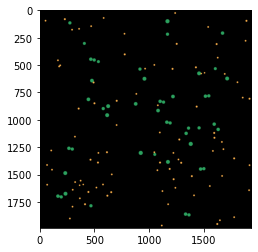

In [6]:
# radius
r1100 =f[radius_key(ts)]

# xyz
x=f['x'][ts]
y=f['y'][ts]
z=f['z'][ts]

#id
id=f['id'][ts]
types=f['type'][ts]
# create a numpy array based on the extracted coordinates, radii, and ids for cells at the given timestep
# should be 4 columns by 3 rows here

cells = np.column_stack((x,y,z,r1100,id,types))

# scale x,y,z and raidius coordinates
px_pm = 2e7  #px per meter
cells[:,0:4] *= px_pm  
#note this updates cells in place, so re-running this block without re-creating the cells array is a Bad Thing
#cells
# determine image size, pad by largest radius + 20 %
im_padding  = max(cells[:,3])*1.2
im_width = int(max(cells[:,0]) + im_padding)
im_height= int(max(cells[:,1]) + im_padding)
# generate a blank image with the calculated dimensions and draw cells on it
# for comparing between timesteps probably just want to use the max x/y coords from all steps
blank_image = np.zeros((im_height,im_width,3), np.uint8)


#plt.imshow(blank_image)

            
def showcell(loc,rad,color):
    cv2.circle(blank_image, loc,rad,color,-1)
green = (44,162,95)
red = (254,178,76)

for cell in cells:
    xy_coord = (int(cell[0]),int(cell[1]))
    radius = int(cell[3])
    if cell[5]==1:
        color = green
    elif cell[5] ==2:
        color = red
    showcell(xy_coord,radius,color)


plt.imshow(blank_image)

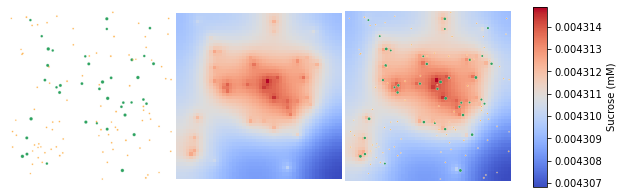

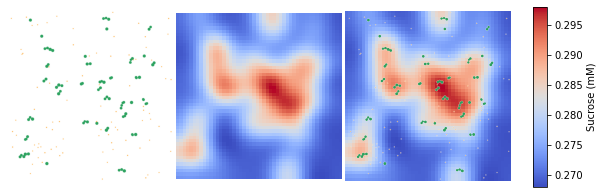

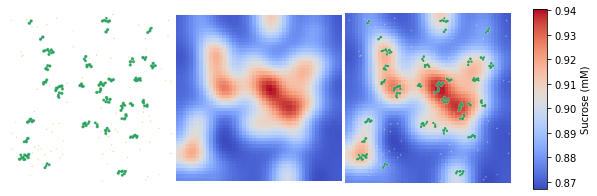

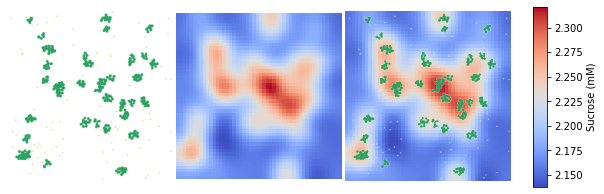

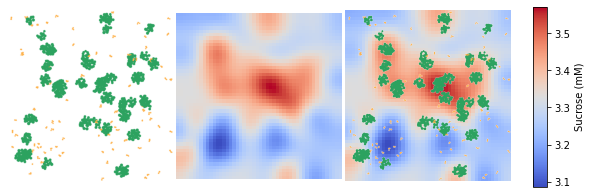

In [7]:
SucroseMW = 342.3
for i,t in enumerate(timepoints):
    if i%50==1:
        # radius
        r =f[radius_key(t)]

        # xyz
        x=f['x'][t]
        y=f['y'][t]
        z=f['z'][t]

        #id
        id=f['id'][t]
        types=f['type'][t]
        # create a numpy array based on the extracted coordinates, radii, and ids for cells at the given timestep
        # should be 4 columns by 3 rows here

        cells = np.column_stack((x,y,z,r,id,types))

        # scale x,y,z and raidius coordinates
        px_pm = 2e7  #px per meter
        cells[:,0:4] *= px_pm 
        blank_image = 255*np.ones((im_height,im_width,3), np.uint8)
        extent = 0, im_width, 0, im_height
        for cell in cells:
            xy_coord = (int(cell[0]),int(cell[1]))
            radius = int(cell[3])
            if cell[5]==1:
                color = green
            elif cell[5] ==2:
                color = red
            showcell(xy_coord,radius,color)
        sucrose = f['concentration']['suc'][t][:,:,:].mean(axis=0)/SucroseMW*1e3
        scaled = cv2.resize(sucrose,(im_height,im_width))
        flipped =cv2.flip(sucrose,0)
        img = Image.fromarray(blank_image)
        img = img.convert("RGBA")

        pixdata = img.load()

        width, height = img.size
        for y in range(height):
            for x in range(width):
                if pixdata[x, y][:3] == (255, 255, 255):
                    pixdata[x, y] = (255,255,255,0)
                else:
                    pixdata[x, y] = (pixdata[x, y][0],pixdata[x, y][1],pixdata[x, y][2],255)
        fig,axes = plt.subplots(ncols=3,figsize=(10,5))

        
        axes[0].imshow(blank_image)
        axes[1].imshow(sucrose,cmap='coolwarm')
        im =  axes[2].imshow(flipped,extent=extent,cmap='coolwarm')
        axes[2].imshow(img)
        
        for ax in axes:
            ax.set_axis_off()
        fig.subplots_adjust(left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)
        cb_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5])
        cbar = fig.colorbar(im, cax=cb_ax)
        cbar.ax.set_ylabel('Sucrose (mM)')
        plt.show()
        

In [8]:
ids = f['id']['0']
#for i in ids:
    #print(i)

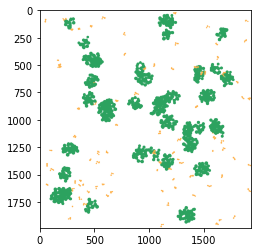

In [9]:
img = Image.fromarray(blank_image)
img = img.convert("RGBA")

pixdata = img.load()

width, height = img.size
for y in range(height):
    for x in range(width):
        if pixdata[x, y][:3] == (255, 255, 255):
            pixdata[x, y] = (255,255,255,0)
        else:
            pixdata[x, y] = (pixdata[x, y][0],pixdata[x, y][1],pixdata[x, y][2],255)
plt.imshow(img)

In [10]:
pixdata[250,1600][:3]

(255, 255, 255)

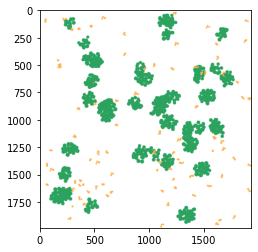

In [11]:
plt.imshow(blank_image)

In [12]:
#for i in ids:
    #print(i,f[radius_key(ts)][i-1])

In [13]:
hrs = [int(x)/360 for x in timepoints]
df = pd.DataFrame(columns=['id','type','time','biomass'])
# loop over all cell ids, c, from time = 0
for c in f['id']['0']:
    # loop over all timepoints t
    for t,h in zip(timepoints,hrs):
        # get list of ids from timepoint t
        ids = f['id'][t]
        arr = ids.__array__(ids.dtype)
        # make sure cell id matches id of interest
        i = np.where(arr == c)[0][0]
        # get radius
        radius = f[radius_key(t)][i]
        volume = 4/3*np.pi*radius**3 #volume in m^3
        # get celltype
        celltype=f['type'][t][i]
        # color cells
        if celltype==1:
            color = '#2ca25f'
            mass = volume*370*1e18 # convert mass in kg to fg
        elif celltype ==2:
            color = '#de2d26'
            mass = volume*236*1e18
        elif celltype ==0:
            print('Celltype is 0',i,c,celltype)
        # append data to a dataframe
        df = df.append(pd.DataFrame([[c,celltype,h,mass]],columns=['id','type','time','biomass']),ignore_index=True)

In [14]:
df

,id,type,time,biomass
0,98,2,0.000000,101.330030
1,98,2,0.277778,99.222813
2,98,2,0.555556,97.166454
3,98,2,0.833333,95.161353
4,98,2,1.111111,93.206903
...,...,...,...,...
31369,126,2,67.777778,76.498848
31370,126,2,68.055556,77.411552
31371,126,2,68.333333,78.322773
31372,126,2,68.611111,79.235678


In [15]:
# id position within the datasets changes over time
for t in timepoints:
    ids = f['id'][t]
    arr = ids.__array__(ids.dtype)
    #for i,id in enumerate(ids):
       # if id ==15:
            #print('15',i,np.where(arr == 15)[0][0])

In [16]:
ids = f['id'][t]
#help(ids)

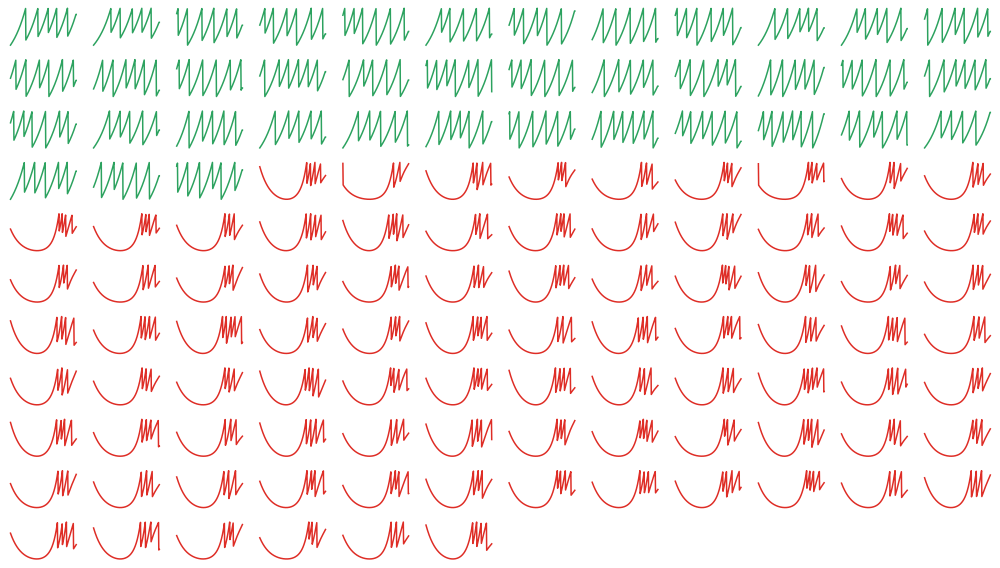

In [17]:
rows=round(np.sqrt(len(df.id.unique())))
cols = int(np.ceil(len(df.id.unique())/rows))
fig ,axes = plt.subplots(nrows=rows,ncols=cols,sharex=True,figsize=(14,8))
axs = axes.ravel()
for i in df.id.unique():
    celltype=df[(df.id==i) & (df.time ==0)].type.values[0]
    if celltype==1:
        color = '#2ca25f'
    elif celltype ==2:
        color = '#de2d26'
    elif celltype ==0:
        print('Celltype is 0',i,c,celltype,t)
    axs[i-1].plot(df[(df.id==i)].biomass.values,c=color)
    #axs[i].set_title(f['type']['0'][c])
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off()
    #ax.spines['bottom'].set_visible(False)
    
fig.tight_layout()
plt.show()
fig.savefig('growthcurvesLow.png',dpi=600)

In [18]:
df[df.type==1].id.unique()

array([10, 36, 6, 23, 28, 13, 7, 38, 33, 17, 29, 35, 25, 3, 37, 5, 21, 24,
       19, 11, 20, 26, 32, 4, 39, 31, 16, 14, 15, 1, 2, 30, 12, 22, 9, 27,
       34, 8, 18], dtype=object)

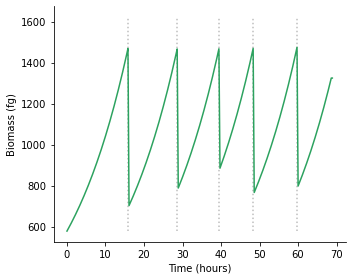

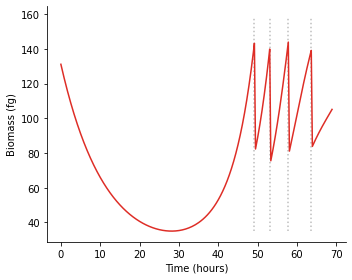

In [19]:
#plot cell size vs time
palette = sns.color_palette("mako_r", 6)
data = df[df.id==1].reset_index()
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(data.time,data.biomass,color='#2ca25f')
#sns.lineplot(x='time',y='biomass',data=data,color = 'green',ax=ax)
for line in find_peaks(data.biomass):
    ax.vlines(data.time[line],data.biomass.min(),data.biomass.max()*1.1,color='#bdbdbd',ls=':')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Biomass (fg)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine()
fig.tight_layout()
fig.savefig('CyanogrowthLow.png',dpi=600)
#plot cell size vs time
palette = sns.color_palette("mako_r", 6)
data = df[df.id==40].reset_index()
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(data.time,data.biomass,color='#de2d26')
#sns.lineplot(x='time',y='biomass',data=data,color = 'green',ax=ax)
for line in find_peaks(data.biomass):
    ax.vlines(data.time[line],data.biomass.min(),data.biomass.max()*1.1,color='#bdbdbd',ls=':')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Biomass (fg)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine()
fig.tight_layout()
fig.savefig('EcgrowthLow.png',dpi=600)

In [20]:
pks,_ = find_peaks(data.biomass)

In [21]:
pks[0]

177

In [22]:
p0 = 0
for p1 in pks:
    #plt.plot(data.time[p0:p1],data.diameter[p0:p1])
    #plt.show()
    dt = data.time[p1]-data.time[p0]
    dy = data.biomass[p1]-data.biomass[p0]
    dydt = dy/dt
    #print(dydt)
    p0=p1+1

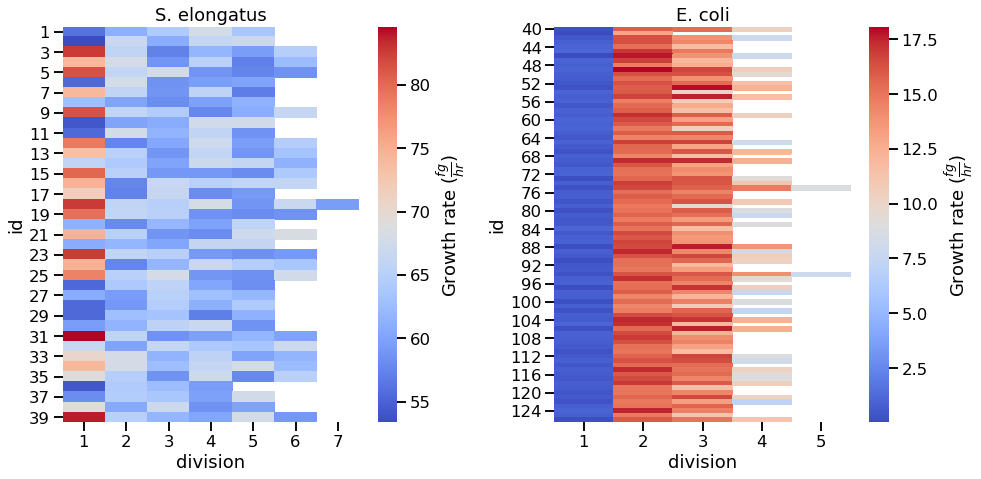

In [23]:
sns.set_context('talk')
fig, axes = plt.subplots(ncols=2,figsize=(14,7))
celltypes = df.type.unique()
celltypes.sort()
for ct in celltypes:
    divs = pd.DataFrame(columns=['id','division','rate'])
    cells = df.id.unique()
    #cells.sort()
    for cell in cells:
        data = df[(df.id==cell) & (df.type==ct)].reset_index()
        pks,_ = find_peaks(data.biomass)
        p0 = 0
        for i,p1 in enumerate(pks):
            #plt.plot(data.time[p0:p1],data.diameter[p0:p1])
            #plt.show()
            dt = data.time[p1]-data.time[p0]
            dy = data.biomass[p1]-data.biomass[p0]
            dydt = dy/dt
            divs = divs.append(pd.DataFrame([[cell,i+1,dydt]],columns=['id','division','rate']),ignore_index=True)
            #print(dydt)
            p0=p1+1
    #plot cell id vs division rate over time
    piv = divs.pivot_table(index='id', columns='division', values='rate')
    g = sns.heatmap(piv, cmap='coolwarm',ax=axes[ct-1])
    cbar = g.collections[0].colorbar
    cbar.ax.set_ylabel(r'Growth rate ($\frac{fg}{hr}$)')
axes[0].set_title('S. elongatus')
axes[1].set_title('E. coli')
fig.tight_layout()
fig.savefig('growth vs division low.png',dpi=600)

In [24]:
df.type.unique()

array([2, 1], dtype=object)

In [25]:
df



,id,type,time,biomass
0,98,2,0.000000,101.330030
1,98,2,0.277778,99.222813
2,98,2,0.555556,97.166454
3,98,2,0.833333,95.161353
4,98,2,1.111111,93.206903
...,...,...,...,...
31369,126,2,67.777778,76.498848
31370,126,2,68.055556,77.411552
31371,126,2,68.333333,78.322773
31372,126,2,68.611111,79.235678


In [26]:

#for i in range(len(df)-1):
#    df.iloc[i+1,-1]=(df.diameter[i+1]-df.diameter[i])/(df.time[i+1]-df.time[i])

<ipython-input-27-5dc22fd31db0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rate'][df.rate < 0] = 0


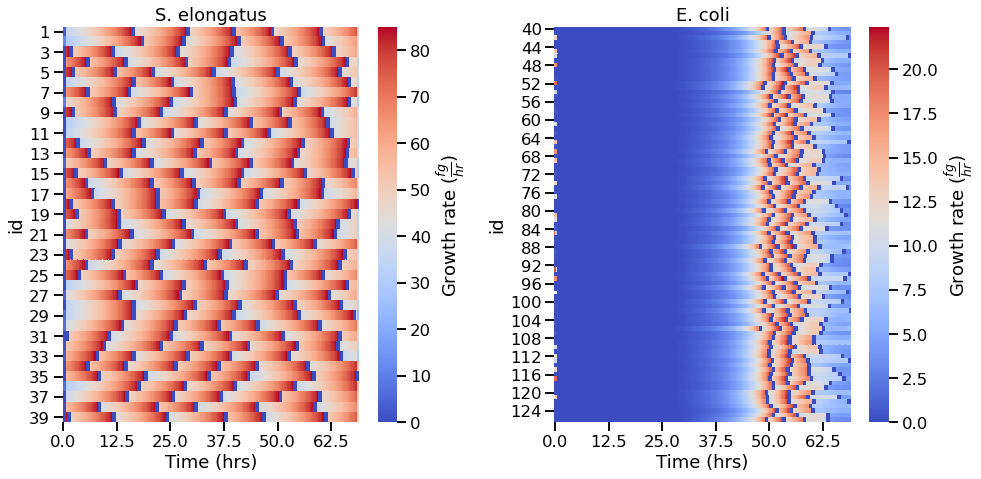

In [27]:
periods = 3
df['rate'] = df.diff(periods=periods).biomass/df.diff(periods=periods).time
df['rate'][df.rate < 0] = 0

sns.set_context('talk')
df.time = df.time.round(1)
fig, axes = plt.subplots(ncols=2,figsize=(14,7))
celltypes = df.type.unique()
celltypes.sort()
for ct in celltypes:
    rates = df[df.type==ct][['id','time','rate']]
    #plot cell id vs division rate over time
    piv = rates.pivot_table(index='id',columns='time', values='rate')
    g = sns.heatmap(piv, cmap='coolwarm',ax=axes[ct-1])
    cbar = g.collections[0].colorbar
    cbar.ax.set_ylabel(r'Growth rate ($\frac{fg}{hr}$)')
    #axes[ct-1].xaxis.set_major_locator(plt.MaxNLocator(5))
    axes[ct-1].set_xticklabels(axes[ct-1].get_xticklabels(), rotation=0) 
    axes[ct-1].locator_params(axis="x", nbins=6)
    axes[ct-1].set_xlabel('Time (hrs)')
    
axes[0].set_title('S. elongatus')
axes[1].set_title('E. coli')

fig.tight_layout()
fig.savefig('Growth rates vs time low.png',dpi=600)

In [28]:
#todo check local nutrient concentration of highly fit cells
#todo make animations with bounds around fit cells and compare with unfit cells
# single cell - input ID, get growth curve, growth rate, nutrients, and timelapse

In [30]:
rates

,id,time,rate
0,98,0.0,NaN
1,98,0.3,NaN
2,98,0.6,NaN
3,98,0.8,0.000000
4,98,1.1,0.000000
...,...,...,...
31369,126,67.8,3.317972
31370,126,68.1,3.299605
31371,126,68.3,3.287743
31372,126,68.6,3.284195


In [48]:
# Import biomass csv
biomass_f = files[14][:-13] + 'Results\\biomass.csv'
print(biomass_f)
Biomass = pd.read_csv(biomass_f,usecols=[0,1,2],delimiter='\t')#,names=['Time','Biomass'],skiprows=1
Biomass.index = Biomass.step/60/60*10 #convert timesteps (10s) to hours
Biomass.index.name='Hours'
Biomass.iloc[:,1:]=Biomass.iloc[:,1:]*1e18
Biomass

..\runs\Run_39_87_5_1\Results\biomass.csv


,step,cyano,ecw
Hours,,,
0.000000,0,36573.88,9431.177
0.277778,100,37176.45,9235.047
0.555556,200,37788.94,9043.815
0.833333,300,38411.52,8857.437
1.111111,400,39044.37,8675.810
...,...,...,...
67.777778,24400,1971478.00,97628.010
68.055556,24500,2003956.00,98996.430
68.333333,24600,2036968.00,100371.700


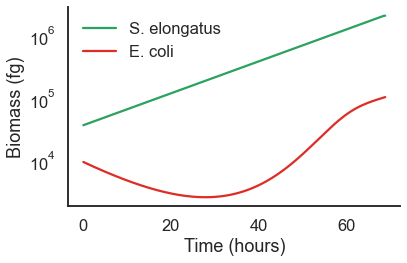

In [49]:
# Plot biomass over time
sns.set_style('white')
fig, ax = plt.subplots()
ax.plot(Biomass.iloc[:,1],label='S. elongatus',color='#2ca25f')
ax.plot(Biomass.iloc[:,2],label='E. coli', color ='#de2d26')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Biomass (fg)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False)

ax.set_yscale('log')
fig.tight_layout()
fig.savefig('BiomassvstimeLow.png',dpi=600)

In [50]:
# Import avg concentration csv
avgc_f = files[14][:-13] + 'Results\\avg_concentration.csv'
print(avgc_f)
avgc = pd.read_csv(avgc_f,usecols=[0,2,3,4],delimiter='\t',names=['Time','O2','Sucrose','CO2'],skiprows=1)#,names=['Time','Biomass']
avgc.index = avgc.Time/60/60*10 #convert timesteps (10s) to hours
avgc.index.name='Hours'
avgc.drop('Time',inplace=True,axis=1)
#avgc_f.iloc[:,1:]=Biomass.iloc[:,1:]*1e15
SucroseMW = 342.3
O2MW = 32
CO2MW = 44.01
avgc.O2 = avgc.O2/O2MW*1e3
avgc.Sucrose = avgc.Sucrose/SucroseMW*1e3
avgc['CO2'] = avgc['CO2']/CO2MW*1e3
avgc

..\runs\Run_39_87_5_1\Results\avg_concentration.csv


,O2,Sucrose,CO2
Hours,,,
0.000000,0.281250,9.991236e-20,9.997728e+02
0.277778,0.574000,4.310605e-03,9.994767e+02
0.555556,0.871478,8.493812e-03,9.991759e+02
0.833333,1.173797,1.268351e-02,9.988703e+02
1.111111,1.481050,1.688322e-02,9.985594e+02
...,...,...,...
67.777778,923.576250,1.588118e+00,5.842927e+01
68.055556,939.008750,1.579837e+00,4.267326e+01
68.333333,954.698438,1.573063e+00,2.665853e+01


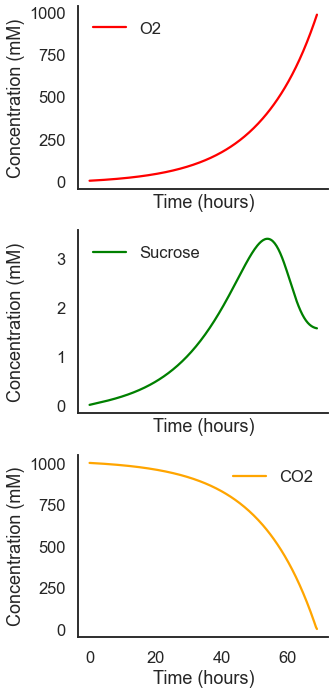

In [38]:
sns.set_context('talk')
sns.set_style('white')
#Plot convcentrations over time
fig, axes = plt.subplots(nrows=3,sharex=True,figsize=(5,10))
axes[0].plot(avgc.iloc[:,0],label='O2',color='red')
axes[1].plot(avgc.iloc[:,1],label='Sucrose',color='green')
axes[2].plot(avgc.iloc[:,2],label='CO2',color='orange')
for ax in axes:
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Concentration (mM)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon=False)
    fig.align_ylabels(axes)
    #ax.set_yscale('log')
fig.tight_layout()
fig.savefig('AvgcvstimeLow.png',dpi=600)

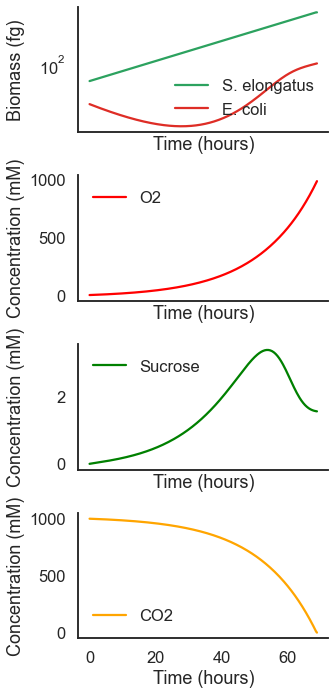

In [42]:
fig, axes = plt.subplots(nrows=4,sharex=True,figsize=(5,10))
axes[0].plot(Biomass.iloc[:,1],label='S. elongatus',color='#2ca25f')
axes[0].plot(Biomass.iloc[:,2],label='E. coli', color ='#de2d26')


axes[1].plot(avgc.iloc[:,0],label='O2',color='red')
axes[2].plot(avgc.iloc[:,1],label='Sucrose',color='green')
axes[3].plot(avgc.iloc[:,2],label='CO2',color='orange')
for ax in axes:
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Concentration (mM)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon=False)
    fig.align_ylabels(axes)
axes[0].set_yscale('log')
axes[0].set_ylabel('Biomass (fg)')
fig.tight_layout()